In [1]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as rxr
import rasterio as rio
import numpy as np
import cartopy.crs as ccrs


ModuleNotFoundError: No module named 'rioxarray'

In [50]:

path_zone_partitions = "zone_partitions.geojson"
path_boundaries_eez = "../build/shapes/eez.geojson"
path_boundaries_onshore = "../data/europe-98-zones.geojson/europe-98-zones.geojson"

path_water_depth = "../data/potentials_offshore/gebco_2023_sub_ice_topo/GEBCO_2023_sub_ice_topo.nc"
path_natura2000 = "../data/potentials_offshore/natura2000_areas/eea_v_3035_100_k_natura2000_p_2021_v12_r01/SHP/Natura2000_end2021_rev1_epsg3035.shp"
path_availability_onshore = "tbd"

zone_partitions = gpd.read_file(path_zone_partitions)
boundaries_eez = gpd.read_file(path_boundaries_eez)
boundaries_onshore = gpd.read_file(path_boundaries_onshore)
natura2000 = gpd.read_file(path_natura2000)


In [53]:

water_depth = xr.open_dataset(path_water_depth)

water_depth = water_depth.coarsen(dim={"lat": 2, "lon": 2}, boundary="trim").mean()
water_depth = water_depth.rio.write_crs("epsg:4326")
water_depth = water_depth.rio.clip(boundaries_eez.geometry).drop("spatial_ref")

threshold = -60
water_shallow = ((water_depth.elevation < 0) & (water_depth.elevation > threshold)).astype(int)
water_deep = ((water_depth.elevation < 0) & (water_depth.elevation < threshold)).astype(int)

In [30]:
path_shipdensity = "../data/potentials_offshore/shipdensity_global/shipdensity_global.tif"
shipdensity = rxr.open_rasterio(path_shipdensity).squeeze(drop=True).squeeze(drop=True)
shipdensity

<xarray.DataArray (y: 33998, x: 72006)>
[2448059988 values with dtype=int32]
Coordinates:
  * x            (x) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 85.0 85.0 84.99 84.99 ... -84.97 -84.98 -84.98
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  6043380549806.992
    STATISTICS_MAXIMUM:      65468393
    STATISTICS_MEAN:         267984.24492993
    STATISTICS_MINIMUM:      0
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       2458328.812386
    _FillValue:              2147483647
    scale_factor:            1.0
    add_offset:              0.0

In [6]:
# shipdensity_coarse = shipdensity.coarsen(dim={"x": 100, "y": 100}, boundary="trim").mean()
shipdensity_clipped = shipdensity.rio.clip(boundaries_eez.iloc[[0]].geometry).drop("spatial_ref")

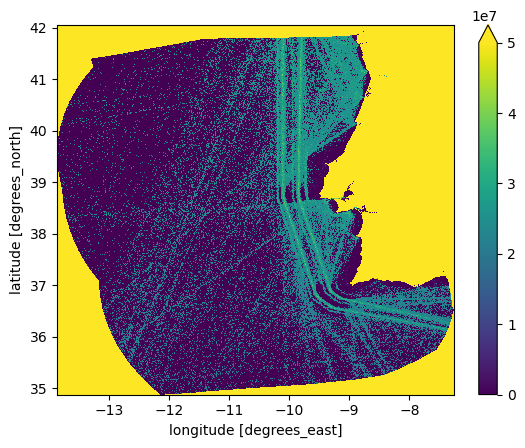

In [7]:
shipdensity_clipped.plot(vmax=5*1e7)

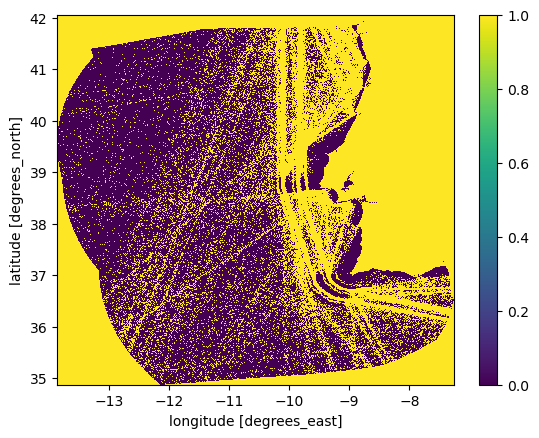

In [17]:
threshold = 2e7
shipdensity_high = (shipdensity_clipped > threshold).astype(int)
shipdensity_high.plot()

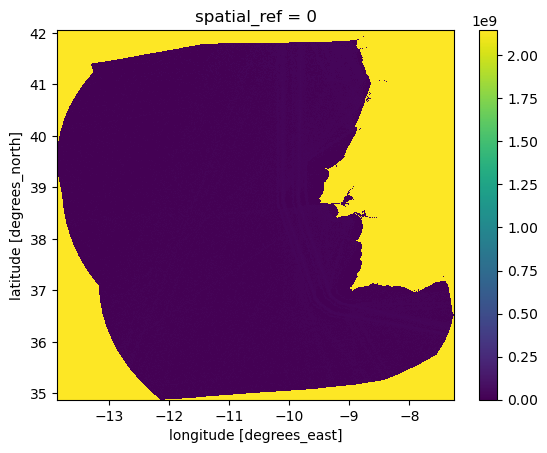

In [132]:

fig, ax= plt.subplots()
shipdensity.squeeze(drop=True).squeeze(drop=True).plot(ax=ax)#, vmin=0, vmax=200000090000)

In [54]:
from matplotlib.colors import ListedColormap, 
colors1 = [(0, 0, 0, 0), "#1aeaef"]
cmap1 = ListedColormap(colors1)
colors2 = [(0, 0, 0, 0), "#675fb5"]
cmap2 = ListedColormap(colors2)
colors3 = [(0, 0, 0, 0), "#100000"]
cmap3 = ListedColormap(colors3)

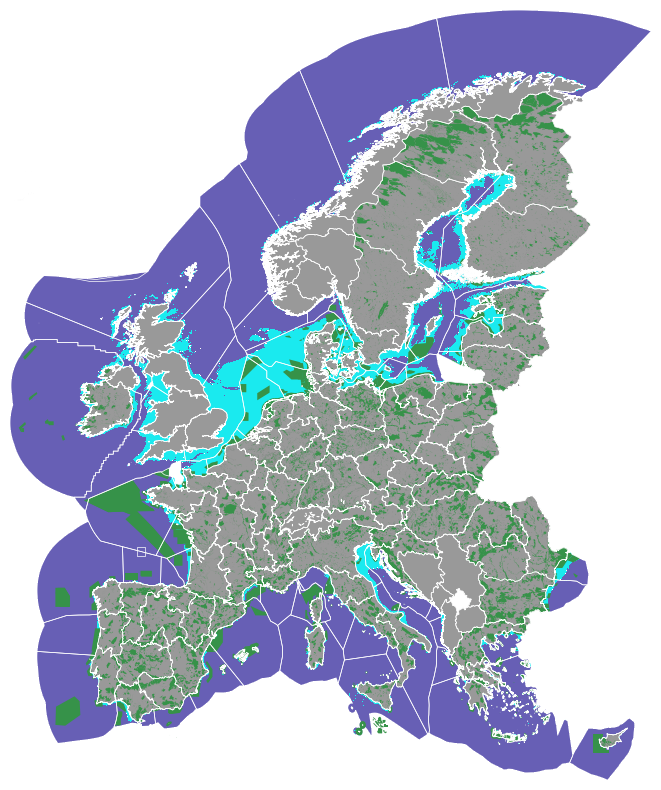

In [23]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

water_shallow.plot(ax=ax, cmap=cmap1, add_colorbar=False)
water_deep.plot(ax=ax, cmap=cmap2, add_colorbar=False)
# boundaries_eez.geometry.boundary.plot(ax=ax, linewidth=0.5, color='#000000')
zone_partitions.geometry.boundary.plot(ax=ax, linewidth=0.5, color="white")
boundaries_onshore.geometry.boundary.plot(ax=ax, linewidth=0.5, color='white')
boundaries_onshore.geometry.plot(ax=ax, color='#000000', alpha=0.4)
natura2000.geometry.to_crs("epsg:4326").plot(ax=ax, color='#369249')

ax.set_axis_off()
plt.show()

In [53]:
shipdensity = shipdensity.squeeze(drop=True).squeeze(drop=True)

In [1]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
shipdensity.plot(ax=ax)
# water_shallow.plot(ax=ax, cmap=cmap1, add_colorbar=False)
# water_deep.plot(ax=ax, cmap=cmap2, add_colorbar=False)
# # boundaries_eez.geometry.boundary.plot(ax=ax, linewidth=0.5, color='#000000')
# zone_partitions.geometry.boundary.plot(ax=ax, linewidth=0.5, color="white")
# boundaries_onshore.geometry.boundary.plot(ax=ax, linewidth=0.5, color='white')
# boundaries_onshore.geometry.plot(ax=ax, color='#000000', alpha=0.4)
natura2000.geometry.to_crs("epsg:4326").plot(ax=ax, color='#369249')

ax.set_axis_off()
plt.show()

NameError: name 'plt' is not defined

/home/jlauner/.conda/envs/jw4a-d2.1/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
/home/jlauner/.conda/envs/jw4a-d2.1/lib/python3.11/site-packages/rioxarray/_io.py:1132: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


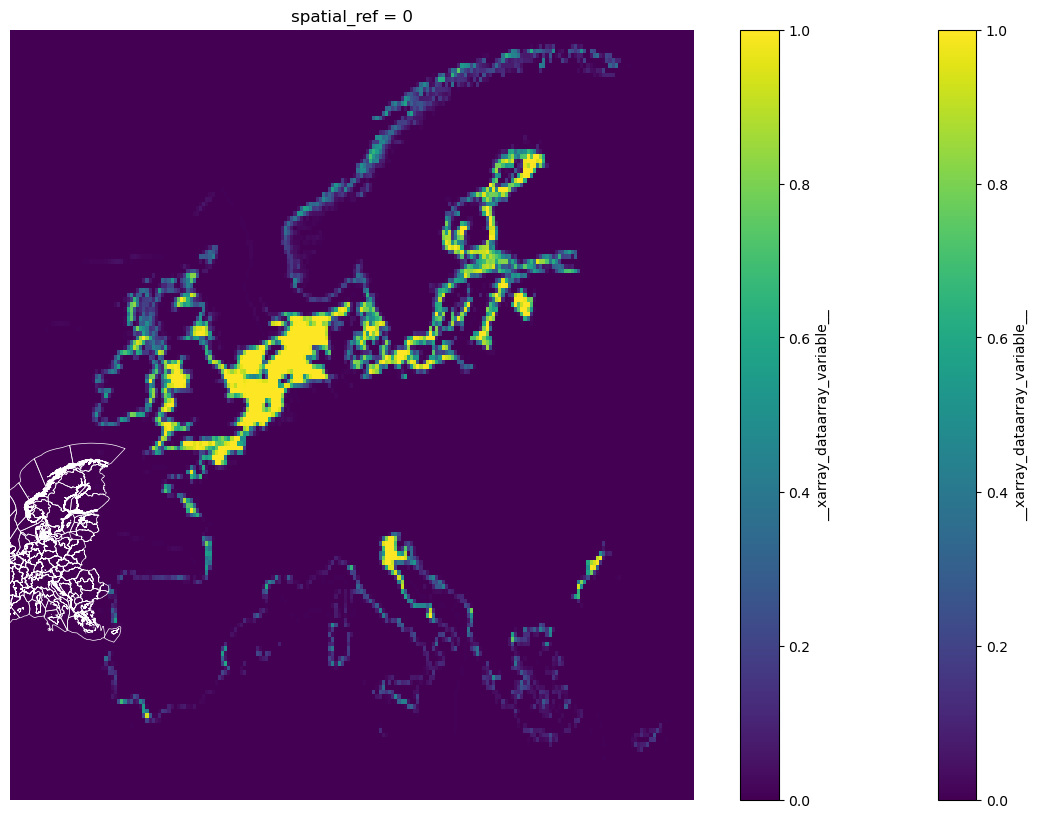

In [29]:
path_availability_deep = "../build/availability/availability_offshore_deep.nc"
path_availability_shallow = "../build/availability/availability_offshore_shallow.nc"

def load_availability(path):
    avalability = rxr.open_rasterio(path)
    avalability = avalability.rio.set_spatial_dims(x_dim="x", y_dim="y")
    ds = avalability.sum("id").squeeze(drop=True).squeeze(drop=True)
    ds = ds.where(ds <= 1, other=1)

    return ds

deep = load_availability(path_availability_deep)
shallow = load_availability(path_availability_shallow)


fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

# water_shallow.plot(ax=ax, cmap=cmap1, add_colorbar=False)
# water_deep.plot(ax=ax, cmap=cmap2, add_colorbar=False)
# boundaries_eez.geometry.boundary.plot(ax=ax, linewidth=0.5, color='#000000')
zone_partitions.geometry.boundary.plot(ax=ax, linewidth=0.5, color="white")
boundaries_onshore.geometry.boundary.plot(ax=ax, linewidth=0.5, color='white')
boundaries_onshore.geometry.plot(ax=ax, color='#000000', alpha=0.4)
natura2000.geometry.to_crs("epsg:4326").plot(ax=ax, color='#369249')
deep.plot(ax=ax)
shallow.plot(ax=ax)
ax.set_axis_off()
plt.show()



In [45]:
import rasterio
from rasterio.mask import mask

# clipping_geometry = gpd.GeoDataFrame(geometry=boundaries_eez.unary_union)
clipping_geometry = gpd.GeoDataFrame(geometry=[boundaries_eez.unary_union], crs=boundaries_eez.crs).geometry
destination = "shipdensity_clipped.tif"
nodata = 0

with rasterio.open(path_shipdensity) as raster_in:
    clipping_geometry = clipping_geometry.to_crs(raster_in.crs)

    raster_out, transform_out = mask(dataset=raster_in, shapes=clipping_geometry, crop=True, nodata=nodata)
    meta_out = raster_in.meta.copy()
    
meta_out.update({
    "driver":"Gtiff",
    "height":raster_out.shape[1],
    "width":raster_out.shape[2],
    "transform":transform_out
})
              
with rasterio.open(destination,'w',**meta_out) as dst:
    dst.write(raster_out)

In [46]:
ds = rxr.open_rasterio(destination)


In [63]:
shipping_density_clipped = ds

from matplotlib.colors import to_rgba 
colors4 = [to_rgba("#000000", 0), "white"]
cmap4 = ListedColormap(colors4)

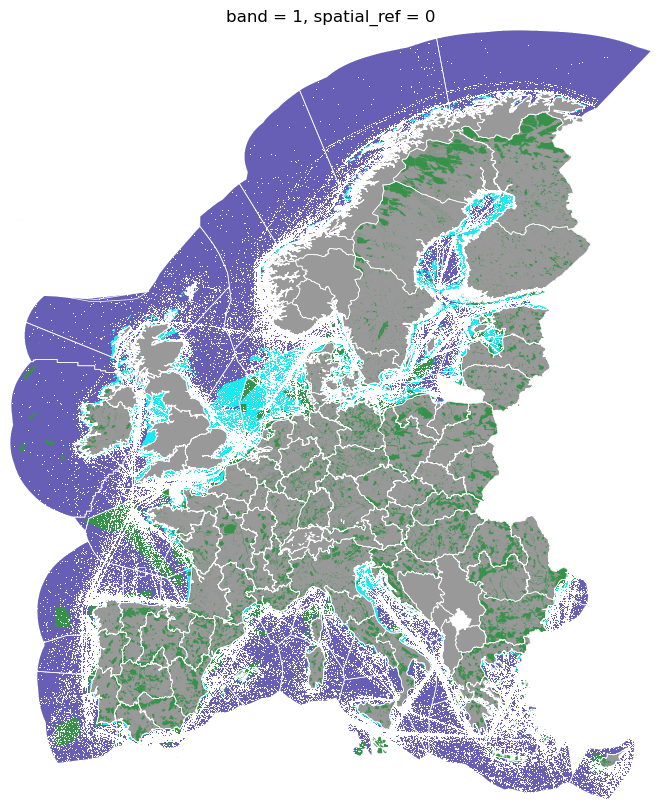

In [66]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()

water_shallow.plot(ax=ax, cmap=cmap1, add_colorbar=False)
water_deep.plot(ax=ax, cmap=cmap2, add_colorbar=False)
# boundaries_eez.geometry.boundary.plot(ax=ax, linewidth=0.5, color='#000000')
zone_partitions.geometry.boundary.plot(ax=ax, linewidth=0.5, color="white")
boundaries_onshore.geometry.boundary.plot(ax=ax, linewidth=0.5, color='white')
boundaries_onshore.geometry.plot(ax=ax, color='#000000', alpha=0.4)
natura2000.geometry.to_crs("epsg:4326").plot(ax=ax, color='#369249')
shipping_density_clipped.plot(ax=ax, cmap=cmap4, add_colorbar=False, vmax=2.5e7)
ax.set_axis_off()
plt.show()

In [ ]:
shipping_density_clipped.smootheplot(ax=ax, cmap=cmap4, add_colorbar=False, vmax=2.5e7)

In [2]:
import geopandas as gpd

In [6]:
path_zone_partitions = "zone_partitions.geojson"
df = gpd.read_file(path_zone_partitions)

ERROR 1: PROJ: proj_create_from_database: Open of /home/jlauner/.conda/envs/jw4a-d2.1/share/proj failed


In [10]:
path_boundaries_eez = "../build/shapes/eez.geojson"
dfd = gpd.read_file(path_boundaries_eez)

In [13]:
dfd

,id,area_km2,geoname,iso_sov1,iso_sov2,iso_ter1,iso_ter2,mrgid,mrgid_eez,mrgid_sov1,...,sovereign2,territory1,territory2,un_sov1,un_sov2,un_ter1,un_ter2,x_1,y_1,geometry
0,3,315501,Portuguese Exclusive Economic Zone,PRT,None,PRT,None,5688,5688,2243,...,None,Portugal,None,620.0,NaN,620.0,NaN,-10.92284,38.31921,"POLYGON ((-7.48092 37.49540, -7.48088 37.49512..."
1,6,427039,Irish Exclusive Economic Zone,IRL,None,IRL,None,5681,5681,2114,...,None,Ireland,None,372.0,NaN,372.0,NaN,-11.74631,52.65269,"POLYGON ((-7.25544 55.06781, -7.25541 55.06787..."
2,15,482910,Greek Exclusive Economic Zone,GRC,None,GRC,None,5679,5679,2099,...,None,Greece,None,300.0,NaN,300.0,NaN,23.93245,36.50714,"POLYGON ((26.03711 40.72984, 26.02346 40.72030..."
3,135,2859,Joint regime area Spain / France,FRA,ESP,FRA,ESP,48966,48966,17,...,Spain,France,Spain,250.0,724.0,250.0,724.0,-5.33333,45.25417,"POLYGON ((-5.00000 45.00833, -5.66667 45.00833..."
4,136,8011,Joint regime area United Kingdom / Denmark (Fa...,GBR,DNK,GBR,FRO,48967,48967,2208,...,Denmark,United Kingdom,Faeroe,826.0,208.0,826.0,234.0,-7.51858,60.03609,"POLYGON ((-5.53417 60.02639, -6.08000 59.94222..."
5,142,67,Joint regime area Italy / France,FRA,ITA,FRA,ITA,48976,48976,17,...,Italy,France,Italy,250.0,380.0,250.0,380.0,9.04886,41.30715,"POLYGON ((9.09889 41.27111, 8.99889 41.27111, ..."
6,143,13,Bosnian and Herzegovinian Exclusive Economic Zone,BIH,None,BIH,None,22491,22491,2136,...,None,Bosnia and Herzegovina,None,70.0,NaN,70.0,NaN,17.59256,42.91656,"POLYGON ((17.64799 42.88872, 17.64387 42.88342..."
7,152,214,Slovenian Exclusive Economic Zone,SVN,None,SVN,None,5692,5692,2188,...,None,Slovenia,None,705.0,NaN,705.0,NaN,13.57896,45.56287,"POLYGON ((13.72261 45.59452, 13.72266 45.59270..."
8,158,536654,Italian Exclusive Economic Zone,ITA,None,ITA,None,5682,5682,2133,...,None,Italy,None,380.0,NaN,380.0,NaN,12.92786,39.65467,"POLYGON ((13.24486 45.76003, 13.24517 45.75947..."
9,160,29606,Romanian Exclusive economic Zone,ROU,None,ROU,None,5689,5689,2241,...,None,Romania,None,642.0,NaN,642.0,NaN,30.07850,44.24109,"POLYGON ((28.58799 43.80846, 28.58649 43.81062..."
